# Dati cumulativi

In [5]:
import json
import requests
import datetime as dt

from IPython.display import display, Math, Latex, Image, HTML, Markdown

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
import matplotlib.ticker as mtick

from scipy.optimize import curve_fit, brentq
from scipy import stats as sps
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd

In this jupyter notebook, we'll analyse italian COVID-19 data gathered from *Dipartimento di Protezione Civile* GitHub repository ([link](https://github.com/pcm-dpc/COVID-19)).

We'll consider following compartments
- **R** recovered (total cumulative recovered cases)
- **D** deaths (total cumulative deaths caused by COVID-19)
- **T** confirmed (total cumulative cases)
  - infected + recovered + deaths
- **I** infected (current positive cases)
  - confirmed - (recovered + deaths)
  - **H** hospitalized + **C** quarantine, where hospitalized can ben mild or severe (intensive care)

![compartments](https://maxpierini.it/ncov/pics/DATI-sito.png)

In [9]:
italy = None
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
italy = pd.read_csv(
    url,
    usecols=[
        'data', 
        'totale_casi', 'totale_positivi',
        'nuovi_positivi', 'variazione_totale_positivi',
        'deceduti', 'dimessi_guariti',
        'isolamento_domiciliare', 'ricoverati_con_sintomi', 'terapia_intensiva'
    ],
    parse_dates=['data'],
    index_col=['data'],
    squeeze=True).sort_index()

In [10]:
print(f"FIRST ENTRY DATE: {italy.index[0]}")

print(f"LAST  ENTRY DATE: {italy.index[-1]}")

period = (
    italy.index[-1] -
    italy.index[0]
).days

print("COVERAGE: {} days".format(period))

print("CURRENT DATE IS:  {}".format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

FIRST ENTRY DATE: 2020-02-24 18:00:00
LAST  ENTRY DATE: 2020-08-31 17:00:00
COVERAGE: 188 days
CURRENT DATE IS:  2020-09-01 14:28:35


# Italia

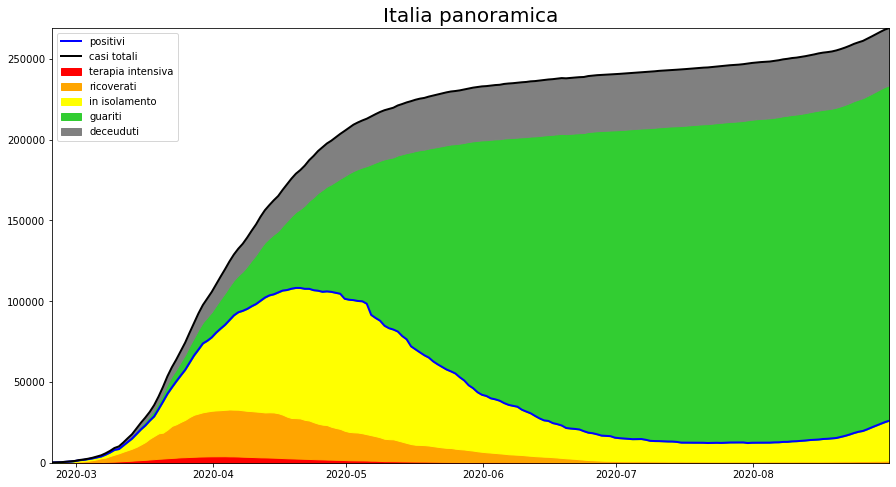

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))

lo = 0
hi = italy['terapia_intensiva']
ax.fill_between(italy.index, lo, hi, color='red', label='terapia intensiva')

lo = italy['terapia_intensiva']
hi = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi']
ax.fill_between(italy.index, lo, hi, color='orange', label='ricoverati')

lo = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi']
hi = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi'] + italy['isolamento_domiciliare']
ax.fill_between(italy.index, lo, hi, color='yellow', label='in isolamento')

ax.plot(italy.index, hi, 'b', label='positivi', lw=2)

lo = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi'] + italy['isolamento_domiciliare']
hi = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi'] + italy['isolamento_domiciliare'] + italy['dimessi_guariti']
ax.fill_between(italy.index, lo, hi, color='limegreen', label='guariti')

lo = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi'] + italy['isolamento_domiciliare'] + italy['dimessi_guariti']
hi = italy['terapia_intensiva'] + italy['ricoverati_con_sintomi'] + italy['isolamento_domiciliare'] + italy['dimessi_guariti'] + italy['deceduti']
ax.fill_between(italy.index, lo, hi, color='grey', label='deceuduti')

ax.plot(italy.index, hi, 'k', label='casi totali', lw=2)

ax.set_xlim(italy.index[0], italy.index[-1])
ax.set_ylim(0, hi.max())

ax.set_title('Italia panoramica', fontsize=20)

plt.legend(loc='upper left')
plt.show();

In [9]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

def hampel_filter_dataframe(dataframe, window, sigmas):
    framedict = {'data': dataframe.index}
    for col in dataframe.columns:
        filtered, _ = hampel_filter_pandas(dataframe[col], window, sigmas)
        framedict.update({col: filtered})
    newframe = pd.DataFrame(framedict)
    newframe.set_index('data', inplace=True)
    return newframe

In [15]:
filtered_italy = hampel_filter_dataframe(italy, 7, 2)

smoothed_italy = filtered_italy.rolling(14,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=5).round()

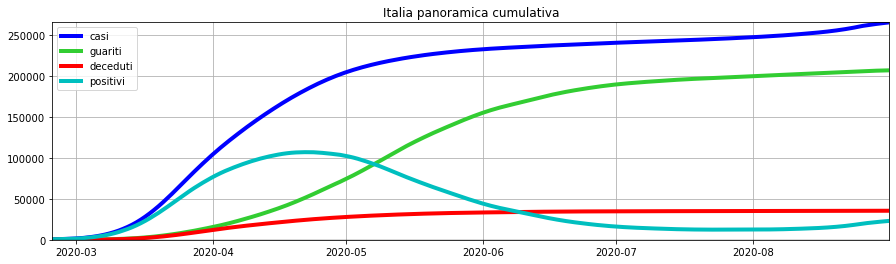

In [27]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(italy.index, smoothed_italy['totale_casi'], 'b', lw=4, label='casi')
ax.plot(italy.index, smoothed_italy['dimessi_guariti'], 'limegreen', lw=4, label='guariti')
ax.plot(italy.index, smoothed_italy['deceduti'], 'r', lw=4, label='deceduti')
ax.plot(italy.index, smoothed_italy['totale_positivi'], 'c', lw=4, label='positivi')

ax.set_xlim(italy.index[0], italy.index[-1])
ax.set_ylim(0, smoothed_italy['totale_casi'].max())
ax.axhline(0, c='k', alpha=.2)

ax.legend(loc='upper left')

ax.set_title("Italia panoramica cumulativa")

plt.grid(axis='both')
plt.show();

# Regioni

In [3]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
states = pd.read_csv(url,
                     #usecols=['data', 'denominazione_regione', 'nuovi_positivi'],
                     parse_dates=['data'],
                     index_col=['denominazione_regione', 'data'],
                     squeeze=True).sort_index()

days = states.index.get_level_values('data').unique()
regions = states.index.get_level_values('denominazione_regione').unique().sort_values()

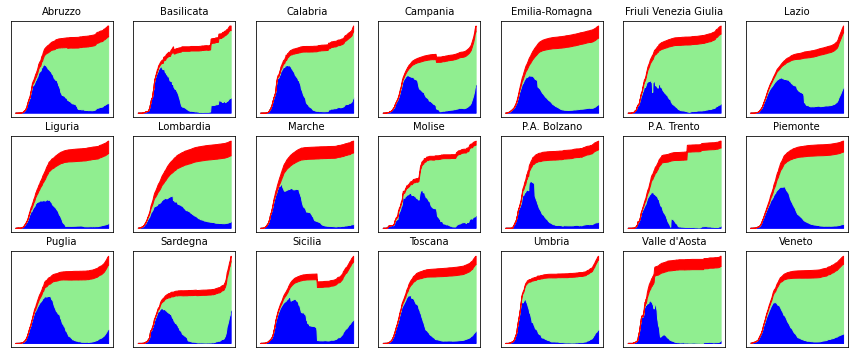

In [13]:
fig, ax = plt.subplots(3, 7, figsize=(15,6))

for i, state in enumerate(states.index.get_level_values('denominazione_regione').unique()):
    f = states.loc[state]
    I = f['totale_positivi']
    R = f['dimessi_guariti']
    D = f['deceduti']
    ax.flat[i].set_title(state, fontsize=10)
    ax.flat[i].fill_between(
        days,
        0, I, color="b"
    )
    ax.flat[i].fill_between(
        days,
        I, R+I, color="lightgreen"
    )
    ax.flat[i].fill_between(
        days,
        R+I, R+I+D, color="r"
    )
    ax.flat[i].set_xticks([])
    ax.flat[i].set_yticks([])

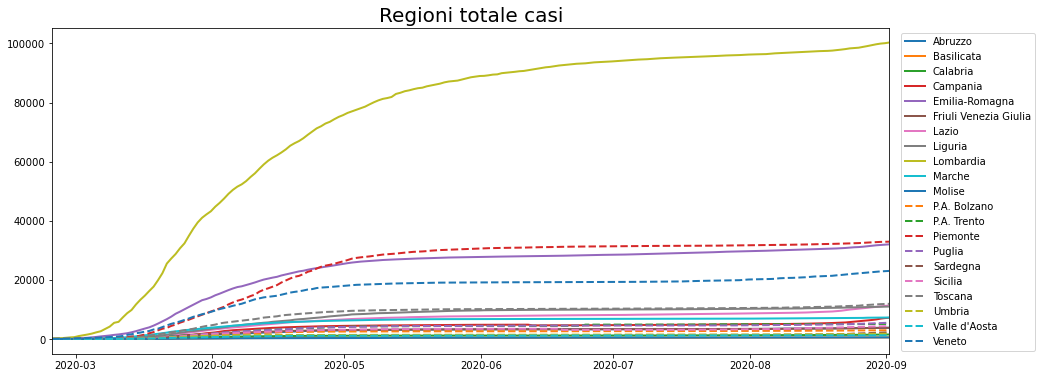

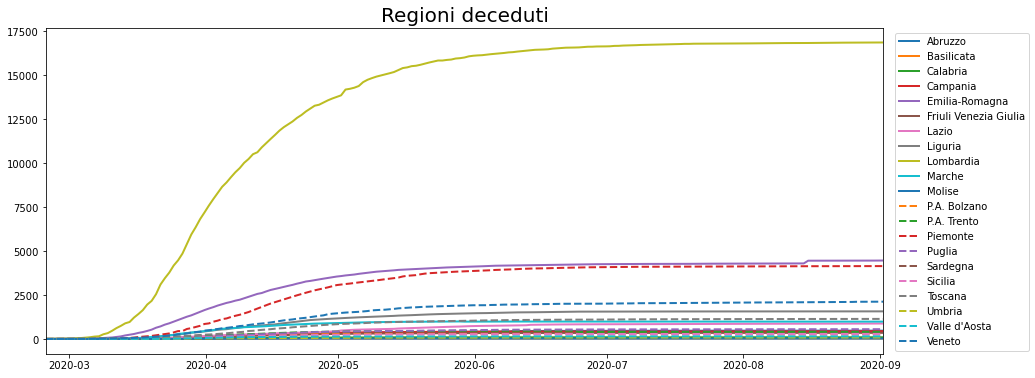

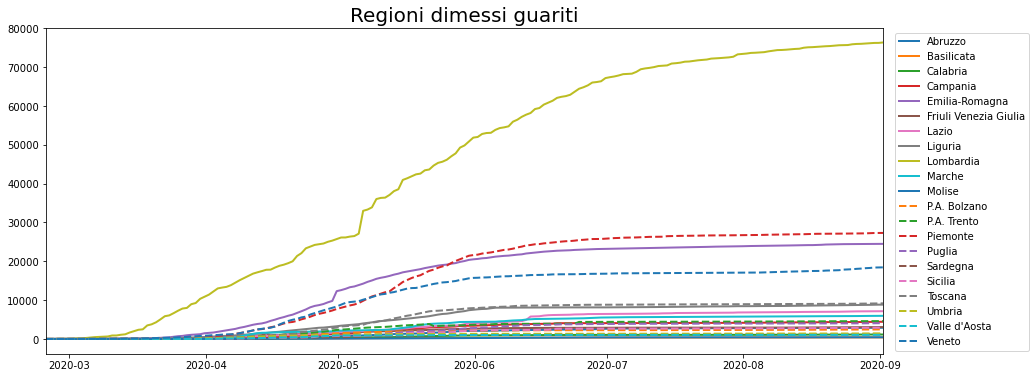

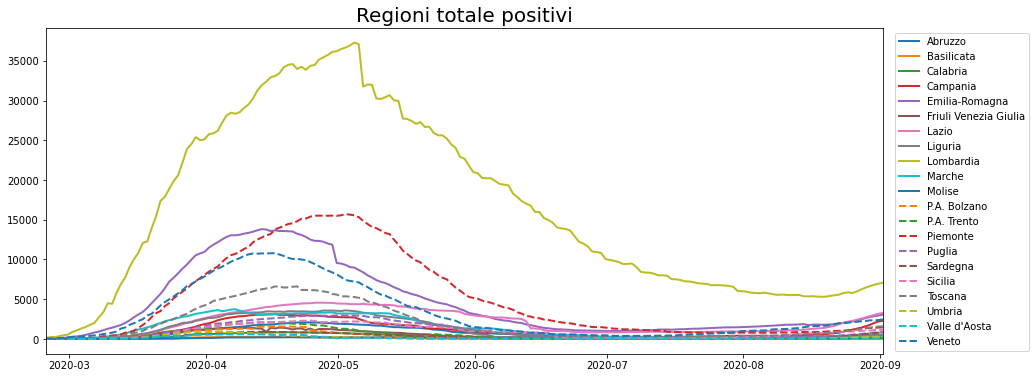

In [37]:
for col in ['totale_casi', 'deceduti', 'dimessi_guariti', 'totale_positivi']:

    fig, ax = plt.subplots(figsize=(15, 6))

    for i, region in enumerate(regions):
        ls = "--" if i > 10 else "-"
        ax.plot(days, states.loc[region][col], label=region, lw=2, ls=ls)

    ax.set_xlim(days[0], days[-1])
    ax.legend(loc='upper right', bbox_to_anchor=(1.18, 1))

    ax.set_title(f"Regioni {col.replace('_', ' ')}", fontsize=20)
    plt.show();

## Abruzzo

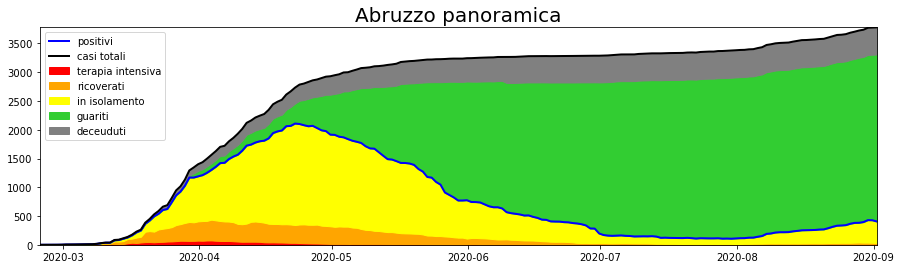

## Basilicata

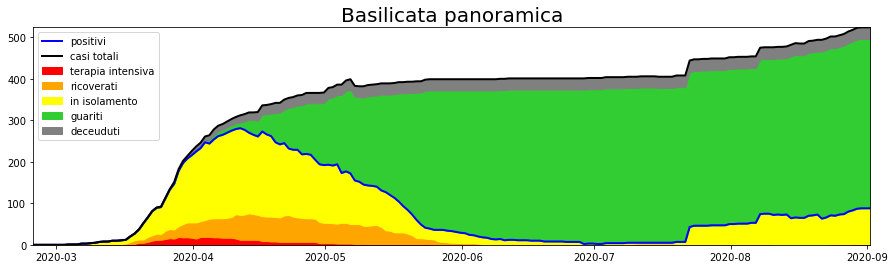

## Calabria

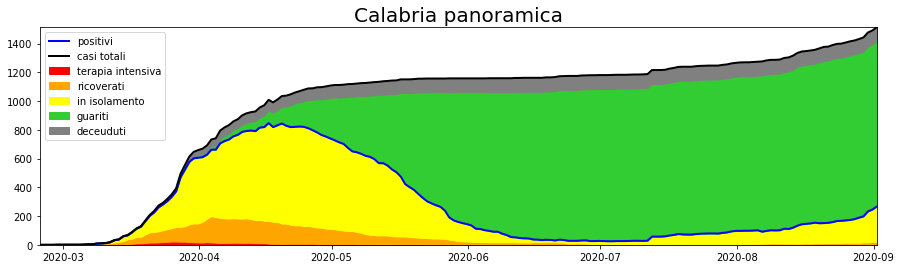

## Campania

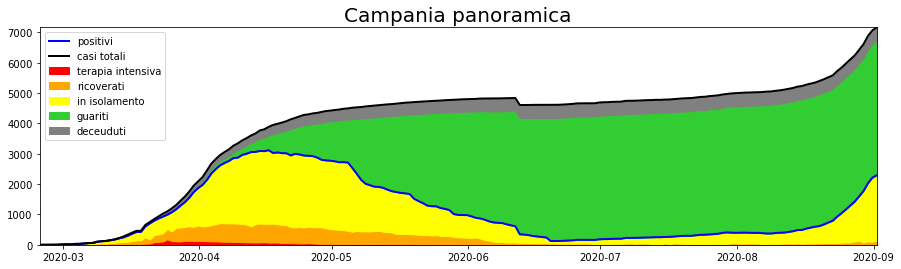

## Emilia-Romagna

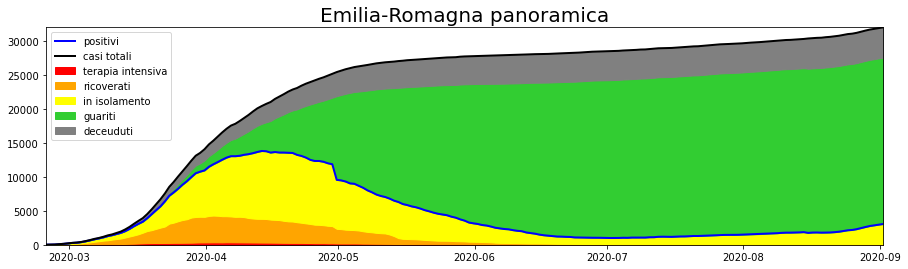

## Friuli Venezia Giulia

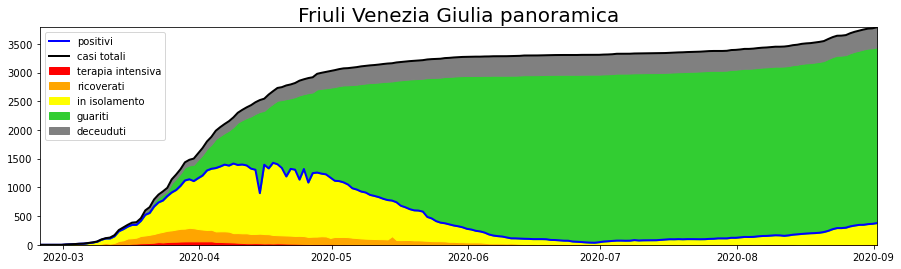

## Lazio

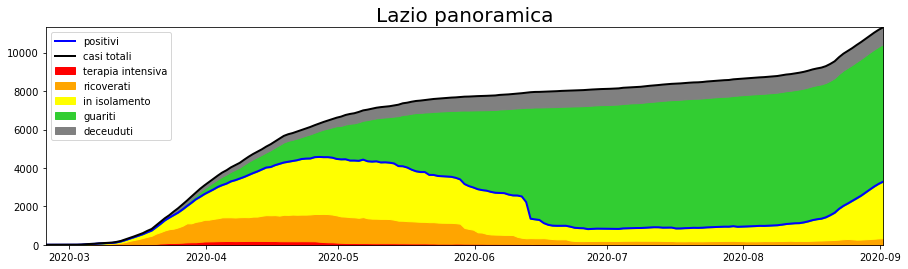

## Liguria

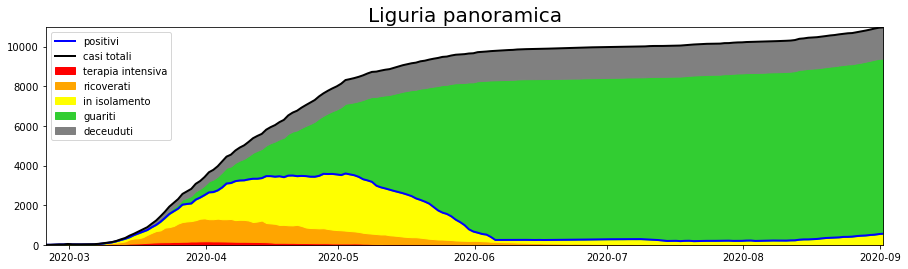

## Lombardia

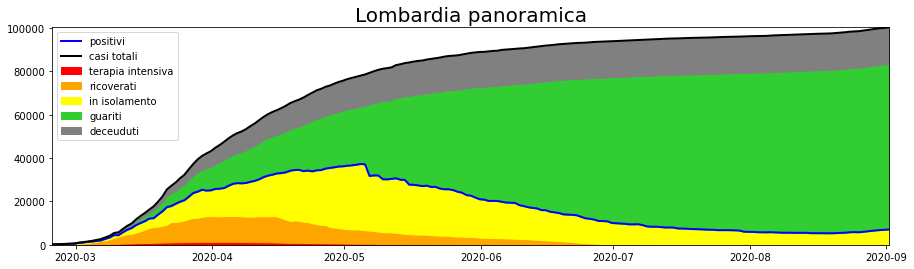

## Marche

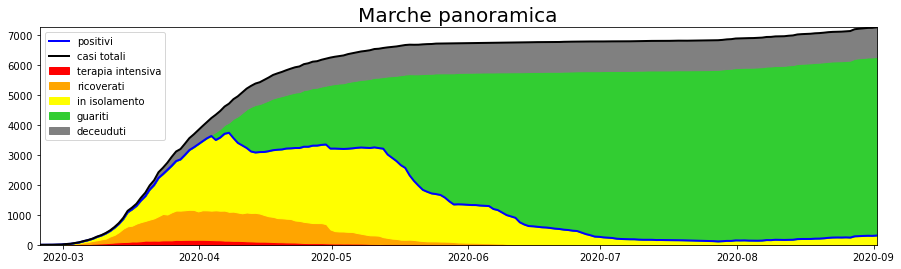

## Molise

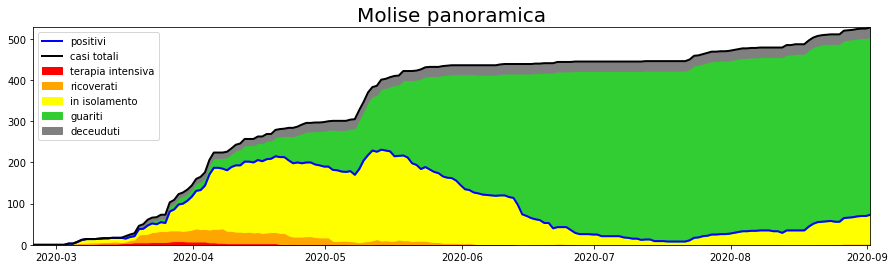

## P.A. Bolzano

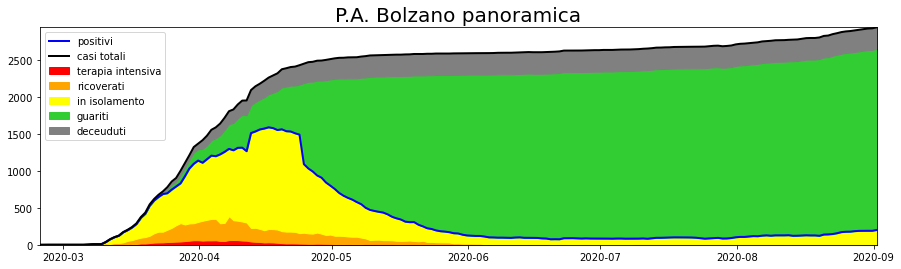

## P.A. Trento

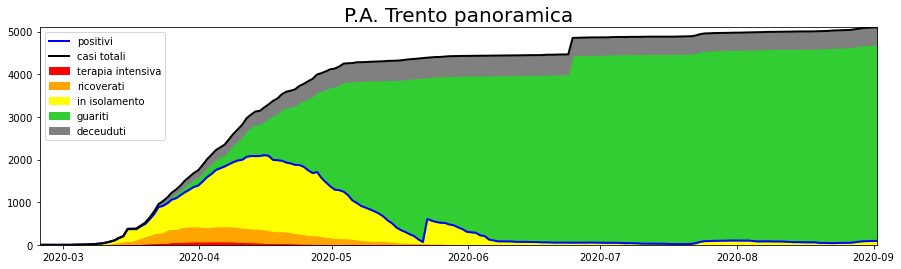

## Piemonte

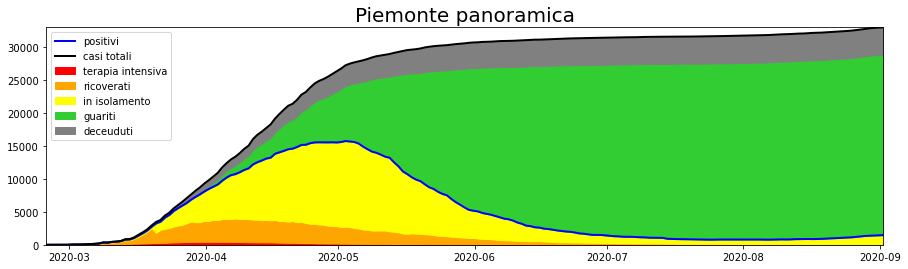

## Puglia

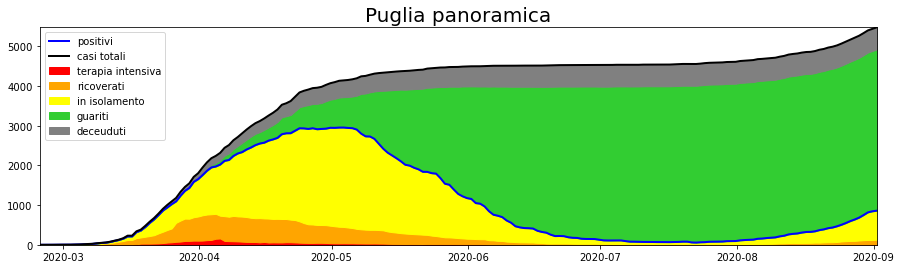

## Sardegna

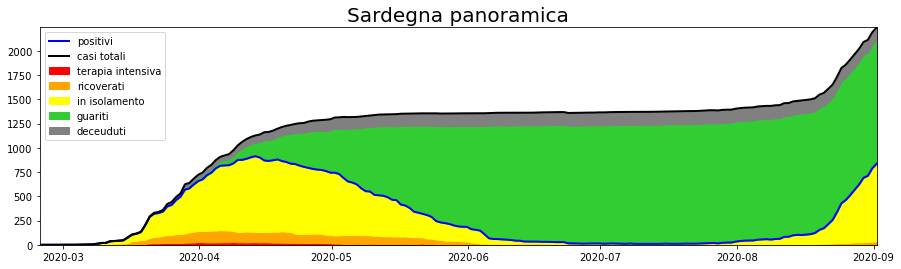

## Sicilia

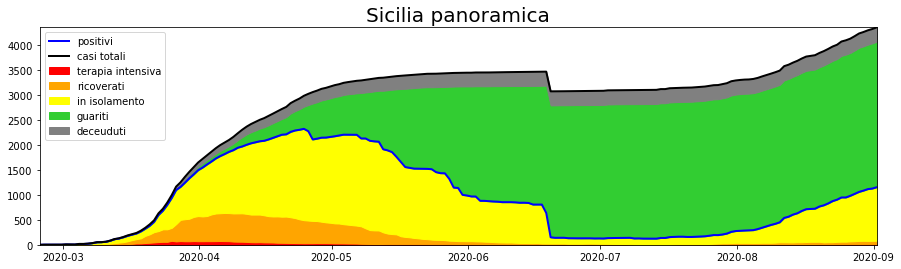

## Toscana

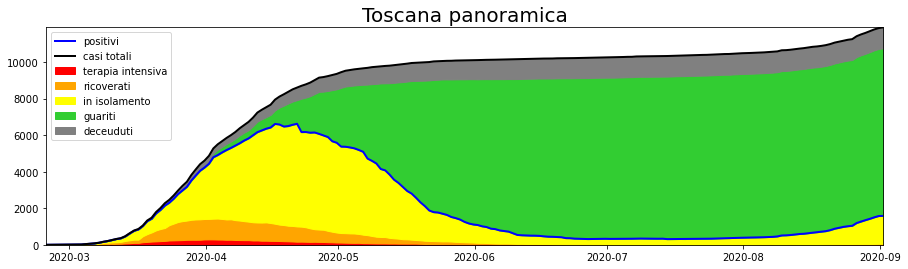

## Umbria

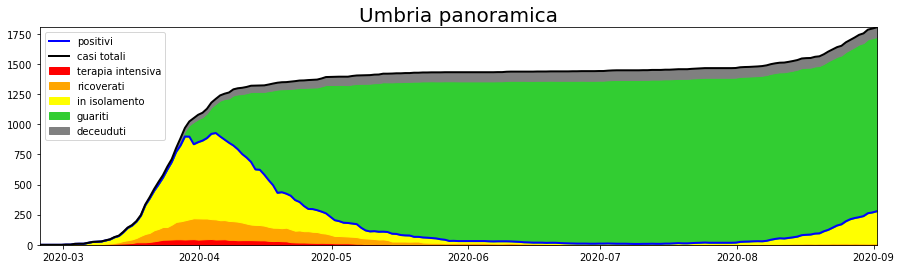

## Valle d'Aosta

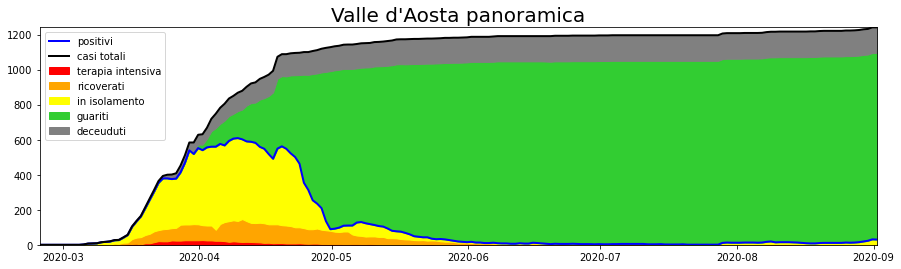

## Veneto

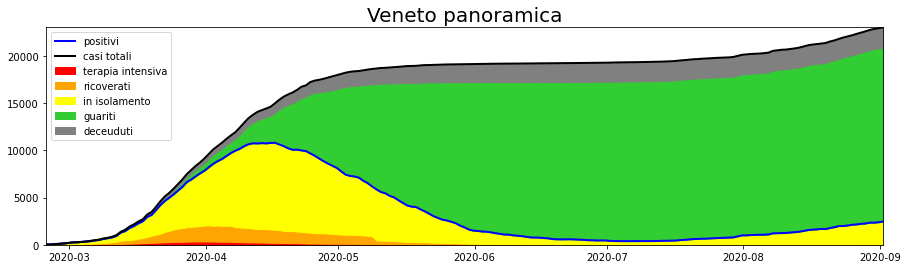

In [38]:
for region in regions:
    display(Markdown(f"## {region}"))
    fig, ax = plt.subplots(figsize=(15, 4))

    lo = 0
    hi = states.loc[region]['terapia_intensiva']
    ax.fill_between(days, lo, hi, color='red', label='terapia intensiva')

    lo = states.loc[region]['terapia_intensiva']
    hi = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi']
    ax.fill_between(days, lo, hi, color='orange', label='ricoverati')

    lo = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi']
    hi = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi'] + states.loc[region]['isolamento_domiciliare']
    ax.fill_between(days, lo, hi, color='yellow', label='in isolamento')

    ax.plot(days, hi, 'b', label='positivi', lw=2)

    lo = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi'] + states.loc[region]['isolamento_domiciliare']
    hi = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi'] + states.loc[region]['isolamento_domiciliare'] + states.loc[region]['dimessi_guariti']
    ax.fill_between(days, lo, hi, color='limegreen', label='guariti')

    lo = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi'] + states.loc[region]['isolamento_domiciliare'] + states.loc[region]['dimessi_guariti']
    hi = states.loc[region]['terapia_intensiva'] + states.loc[region]['ricoverati_con_sintomi'] + states.loc[region]['isolamento_domiciliare'] + states.loc[region]['dimessi_guariti'] + states.loc[region]['deceduti']
    ax.fill_between(days, lo, hi, color='grey', label='deceuduti')

    ax.plot(days, hi, 'k', label='casi totali', lw=2)

    ax.set_xlim(days[0], days[-1])
    ax.set_ylim(0, hi.max())

    ax.set_title(f'{region} panoramica', fontsize=20)

    plt.legend(loc='upper left')
    plt.show()
    plt.close(fig='all')
    
    

***

# Letalità e Guarigione

!!! PLEASE NOTE !!!

These rates are only useful for **SIRD** epidemiological model ([read here for details](https://maxpierini.it/R0.pdf)) not to define COVID-19 actual rates.

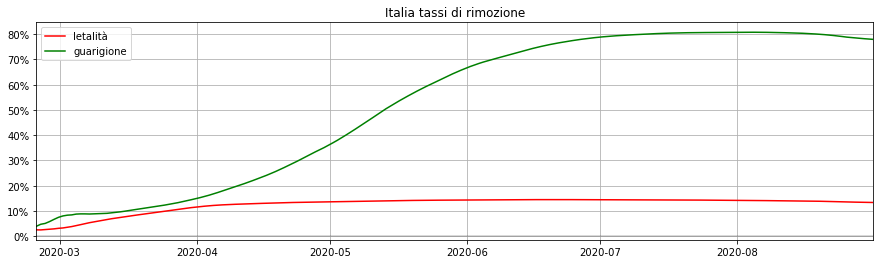

In [37]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(italy.index, smoothed_italy['deceduti']/smoothed_italy['totale_casi'], 'r', label='letalità')
ax.plot(italy.index, smoothed_italy['dimessi_guariti']/smoothed_italy['totale_casi'], 'g', label='guarigione')

ax.set_xlim(italy.index[0], italy.index[-1])

ax.axhline(0, c='k', alpha=.2)

ax.set_title("Italia tassi di rimozione")
ax.legend(loc='upper left')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.grid(axis='both')
plt.show();

***

# Ospedalizzazione e Isolamento

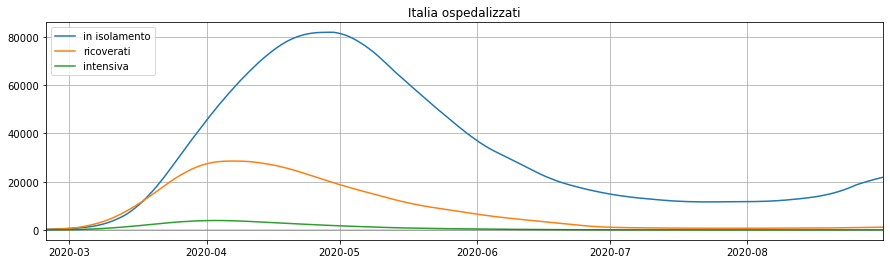

In [39]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(italy.index, smoothed_italy['isolamento_domiciliare'], label='in isolamento')
ax.plot(italy.index, smoothed_italy['ricoverati_con_sintomi'], label='ricoverati')
ax.plot(italy.index, smoothed_italy['terapia_intensiva'], label='intensiva')

ax.set_xlim(italy.index[0], italy.index[-1])

ax.axhline(0, c='k', alpha=.2)

ax.set_title("Italia ospedalizzati")
ax.legend(loc='upper left')

plt.grid(axis='both')
plt.show();

***

# Mobilità

In [41]:
google = pd.read_csv(
    "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv",
    usecols=[
        "date", "country_region_code", "country_region", "sub_region_1", "sub_region_2",
        "retail_and_recreation_percent_change_from_baseline",
        "grocery_and_pharmacy_percent_change_from_baseline",
        "parks_percent_change_from_baseline",
        "transit_stations_percent_change_from_baseline",
        "workplaces_percent_change_from_baseline",
        "residential_percent_change_from_baseline"
    ],
    parse_dates=['date'], dtype={"sub_region_1": str, "sub_region_2": str},
    index_col=["date"]
)
google.to_pickle("google-mobility.pkl")
ITALY = google.loc[google["country_region_code"] == "IT"]
National = ITALY.loc[ITALY.fillna("NONE")["sub_region_1"] == "NONE"]

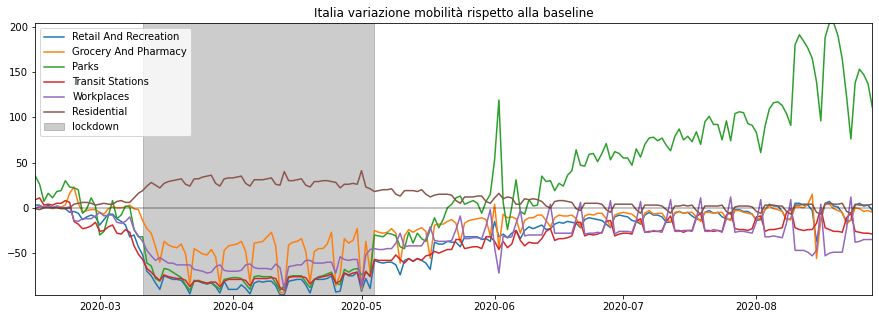

In [42]:
fig, ax = plt.subplots(figsize=(15, 5))

for column in National.columns[4:]:
    ax.plot(National[column], label=column.replace("_", " ").title().split(" Percent")[0])

ax.axhline(0, c='k', alpha=.3)
ax.fill_betweenx(
    [-500, 500], 
    pd.Timestamp("2020-03-11"), pd.Timestamp("2020-05-04"), 
    color='k', alpha=.2, label='lockdown'
)

ax.set_ylim(
    National[National.columns[4:]].values.min(),
    National[National.columns[4:]].values.max()
)
ax.set_xlim(National.index[0], National.index[-1])
ax.set_title('Italia variazione mobilità rispetto alla baseline')
ax.legend()

plt.show();